<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#[RL-X-02]" data-toc-modified-id="[RL-X-02]-0.0.1">[RL-X-02]</a></span></li></ul></li></ul></li><li><span><a href="#OpenAI-gym-FrozenLake-v0-(deterministic)" data-toc-modified-id="OpenAI-gym-FrozenLake-v0-(deterministic)-1">OpenAI gym FrozenLake-v0 (deterministic)</a></span></li><li><span><a href="#ε-greedy" data-toc-modified-id="ε-greedy-2"><em>ε-greedy</em></a></span><ul class="toc-item"><li><span><a href="#1.-Descripción" data-toc-modified-id="1.-Descripción-2.1">1. Descripción</a></span></li><li><span><a href="#2.-Modelo" data-toc-modified-id="2.-Modelo-2.2">2. Modelo</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#2.1-ε-constante" data-toc-modified-id="2.1-ε-constante-2.2.0.1">2.1 <strong>ε</strong> constante</a></span></li><li><span><a href="#2.2-ε-decreciente" data-toc-modified-id="2.2-ε-decreciente-2.2.0.2">2.2 <strong>ε</strong> decreciente</a></span></li></ul></li></ul></li></ul></li></ul></div>

#### [RL-X-02]
## OpenAI gym FrozenLake-v0 (deterministic)
## _ε-greedy_
---

### 1. Descripción
El nuevo modelo definirá un nuevo _hiperparámetro_ **epsilon**. Este parámetro establecerá la **probabilidad** de que nuestro agente tome una acción aleatoria en lugar de la determinada por su _policy_.

Aunque en principio este mecanismo puede parecer un tanto absurdo o ineficiente, nos permite balancear dos conceptos básicos del aprendizaje por refuerzo: **explotación** vs **exploración**. La explotación hace referencia a adoptar la acción más conveniente (de mayor recompensa) mientras que exploración hace referencia a realizar acciones (generalmente aleatorias) que puedan conducir a un mejor conocimiento del entorno.

La razón fundamental para una aproximación de este tipo es que, si para un estado dado, siempre optamos por la acción de mayor recompensa (actual), es muy probable que no lleguemos a descubrir otras alternativas que podrían llevarnos a mayores recompensas futuras. Por ejemplo, si siempre vamos a comer a nuestro restaurante favorito y no probamos, de vez en cuando, otras alternativas, negamos la posibilidad de descubrir un nuevo restaurante que podría gustarnos más.

En nuestro agente **sólo** se "activará" la exploración si se encuentra en modo de entrenamiento, ya que, fuera del entrenamiento, no se actualizan los _Q-values_

### 2. Modelo
---
Vamos a añadir a nuestro agente nuevos parámetros para controlar la exploración:

- **_eps_** (**ε**) probabilidad de exploración (default=0.0)
- **_eps\_dec_** factor de decremento temporal (default=1.0)
- **_eps\_end_** valor final de ε (default=0.0)

Los parámetros _eps\_dec_ y _eps\_end_ nos permite controlorar la variación de _epsilon_ a lo largo del entrenamiento.



In [7]:
import torch
import numpy as np

class FrozenLakeAgent():
    """Agent class for FrozenLake environment.
    """
    def __init__(self, env, train=False, gamma=1.0, eps=0.0, eps_end=0.0, eps_dec=1.0):
        self._env = env
        self._nS = self._env.nS
        self._nA = self._env.nA
        self._train = train
        self._gamma = gamma
        self._eps = eps
        self._eps_end = eps_end
        self._eps_dec = eps_dec        
        self._state = 0
        self._Q = torch.zeros((self._nS, self._nA))
        
    def reset(self, state):
        self._state = state
        
    def get_action(self):
        action = None
    
        # exploitation vs exploration
        if self._train and torch.rand(1).item() < self._eps:
            action = self._env.action_space.sample() # exploration (random move)
        else: 
            action = torch.max(self._Q + torch.randn(self._nA)/1E3, dim=1)[1][self._state].item()
        
        # update epsilon
        if self._train and self._eps > self._eps_end:
            self._eps *= self._eps_dec       

        return action
    
    def update(self, new_state, r, action):
        if self._train:
            # update Q-value
            self._Q[self._state, action] = r + self._gamma*torch.max(self._Q, dim=1)[0][new_state].item()
        self._state = new_state
        
    def load_model(self, file_name):
        nQ = np.loadtxt(file_name, dtype=np.float32, delimiter=";")
        self._Q = torch.from_numpy(nQ)
        
    def save_model(self, file_name):
        np.savetxt(file_name, self._Q.detach().cpu().numpy(), delimiter=";")
        
    def print_model(self):
        # show Q-values
        print("\n\nQ-values:\n")
        print(f"{'LE':^7}{'DW':^7}{'RI':^7}{'UP':^7}")
        print("-" * (7 * self._Q.shape[1] - 1))        
        for r in range(self._Q.shape[0]):
            for c in range(self._Q.shape[1]):
                print(f"{self._Q[r,c]:6.3f} ",end="")
            print()
            if (r+1) % self._Q.shape[1] == 0:
                print("-" * (7 * self._Q.shape[1] - 1))
        


##### 2.1 **ε** constante
---
En este primer caso, definiremos un agente que en el que el valor de **ε** será **constante** durante todo el proceso de aprendizaje, por lo que los valores de los parámetros _eps_ y _eps_\__end_ serán iguales (o el factor de decremento =1.0)

IntProgress(value=0, description='Episodes [500]:', max=500, style=ProgressStyle(bar_color='#44a0fd'))



Q-values:

  LE     DW     RI     UP   
---------------------------
 1.000  1.000  1.000  1.000 
 1.000  0.000  0.000  1.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------
 1.000  1.000  0.000  1.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------
 1.000  0.000  1.000  1.000 
 1.000  1.000  1.000  0.000 
 0.000  1.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------
 0.000  0.000  0.000  0.000 
 0.000  1.000  1.000  1.000 
 1.000  0.000  1.000  1.000 
 0.000  0.000  0.000  0.000 
---------------------------

Episodes solved:  391
Average episodes solved:  0.782
Last-100 episodes solved:  88
Last-100 avg episodes solved:  0.88

Average steps:  19.672
Last-100 avg steps:  38.5


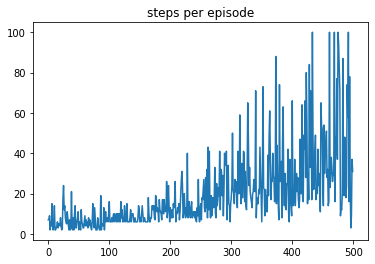


Average reward:  0.782
Last-100 avg reward:  0.88


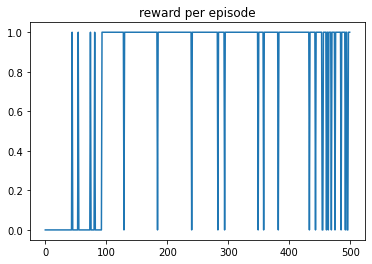

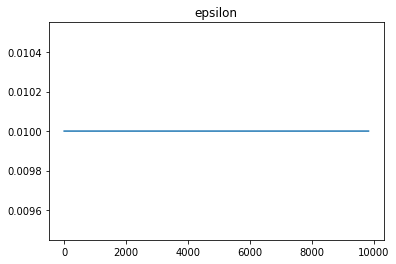

In [13]:
# Jupyter widgets
import ipywidgets as widgets

# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

from matplotlib import pyplot as plt

# -- TUNNING ----------------------------------------------------------------------
_EPISODES = 500
_REWD_HOLE = .0 # fall into the hole reward
_REWD_WALL = .0 # stumble into the wall
_REWD_GOAL = 1.
_GAMMA = 1. # look ahead
_EPS_INI = 0.01 # ε-greedy
# ---------------------------------------------------------------------------------

# progress bar widget
w_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=_EPISODES,
    description=f'Episodes [{_EPISODES}]:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': '#44a0fd'},
    orientation='horizontal'
)
display(w_bar)

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=False, sound=False, render=False)
env.rewd_hole = _REWD_HOLE
env.rewd_wall = _REWD_WALL
env.rewd_goal = _REWD_GOAL

# Agent
agent = FrozenLakeAgent(env, train=True, gamma=1, eps=_EPS_INI)

# stats
episodes_rewards = []
episodes_steps = []
episodes_solved = []
epsilon = []

for i in range(_EPISODES):
    # widget update
    w_bar.description = f'Episode [{i+1:03}]:'
    w_bar.value = i+1
    
    eps_steps = 0  # total episode steps
    eps_reward = 0 # total episode reward
    
    state = env.reset() # initial state
    agent.reset(state)
        
    done = False  # episode done?
    while not done:
        # get action
        action = agent.get_action()
              
        # perform action
        new_state, reward, done, _ = env.step(action)
        
        # update Q-values
        agent.update(new_state, reward, action)
        
        # update stats
        eps_steps += 1
        eps_reward += reward
        epsilon.append(agent._eps)
        
    episodes_rewards.append(eps_reward)
    episodes_steps.append(eps_steps)
    episodes_solved.append(1 if env.goal else 0)    
    
# print model
agent.print_model()

# show stats
print(f"\nEpisodes solved: ", sum(episodes_solved))
print(f"Average episodes solved: ", sum(episodes_solved)/len(episodes_solved))
print(f"Last-100 episodes solved: ", sum(episodes_solved[-100:]))
print(f"Last-100 avg episodes solved: ", sum(episodes_solved[-100:])/100)

print(f"\nAverage steps: ", sum(episodes_steps)/len(episodes_steps))
print(f"Last-100 avg steps: ", sum(episodes_steps[-100:])/100)
plt.plot(episodes_steps)
plt.title("steps per episode")
plt.show()

print(f"\nAverage reward: ", sum(episodes_rewards)/len(episodes_rewards))
print(f"Last-100 avg reward: ", sum(episodes_rewards[-100:])/100)
plt.plot(episodes_rewards)
plt.title("reward per episode")
plt.show()

plt.plot(epsilon)
plt.title("epsilon")
plt.show()

##### 2.2 **ε** decreciente
---
En este segundo caso, partiremos de un valor elevado de **ε** que iremos decrementando a medida que el agente vaya tomando acciones

IntProgress(value=0, description='Episodes [500]:', max=500, style=ProgressStyle(bar_color='#44a0fd'))

Training...

Episode:

Q-values:

  LE     DW     RI     UP   
---------------------------
 1.000  1.000  1.000  1.000 
 1.000  0.000  1.000  1.000 
 0.000  1.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------
 1.000  1.000  0.000  1.000 
 0.000  0.000  0.000  0.000 
 0.000  1.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
---------------------------
 1.000  0.000  1.000  1.000 
 1.000  1.000  1.000  0.000 
 1.000  1.000  0.000  1.000 
 0.000  0.000  0.000  0.000 
---------------------------
 0.000  0.000  0.000  0.000 
 0.000  1.000  1.000  0.000 
 1.000  1.000  1.000  1.000 
 0.000  0.000  0.000  0.000 
---------------------------

Episodes solved:  343
Average episodes solved:  0.686
Last-100 episodes solved:  99
Last-100 avg episodes solved:  0.99

Average steps:  25.306
Last-100 avg steps:  29.68


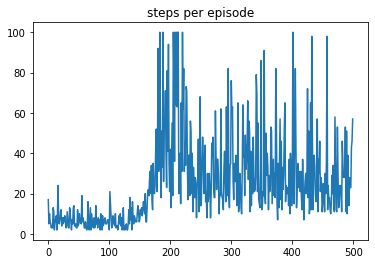


Average reward:  0.686
Last-100 avg reward:  0.99


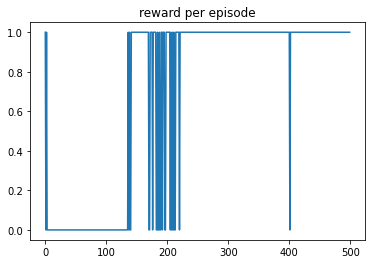

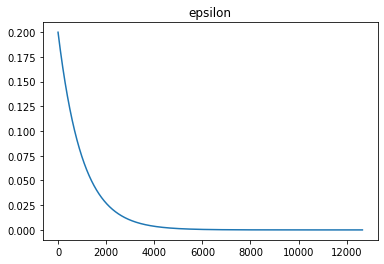

In [12]:
# Jupyter widgets
import ipywidgets as widgets

# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

from matplotlib import pyplot as plt

# -- TUNNING ----------------------------------------------------------------------
_EPISODES = 500
_REWD_HOLE = .0 # fall into the hole reward
_REWD_WALL = .0 # stumble into the wall
_REWD_GOAL = 1.
_GAMMA = 1. # look ahead
_EPS_INI = 0.2 # ε-greedy
_EPS_END = 0.0
_EPS_DEC = 0.999
# ---------------------------------------------------------------------------------

# progress bar widget
w_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=_EPISODES,
    description=f'Episodes [{_EPISODES}]:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': '#44a0fd'},
    orientation='horizontal'
)
display(w_bar)

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=False, sound=False, render=False)
env.rewd_hole = _REWD_HOLE
env.rewd_wall = _REWD_WALL
env.rewd_goal = _REWD_GOAL

# Agent
agent = FrozenLakeAgent(env, train=True, gamma=1, eps=_EPS_INI, eps_end=_EPS_END, eps_dec=_EPS_DEC)

# stats
episodes_rewards = []
episodes_steps = []
episodes_solved = []
epsilon = []

print("Training...")
print("\nEpisode:", end="") 
for i in range(_EPISODES):
    # widget update
    w_bar.description = f'Episode [{i+1:03}]:'
    w_bar.value = i+1
    
    eps_steps = 0  # total episode steps
    eps_reward = 0 # total episode reward
    
    state = env.reset() # initial state
    agent.reset(state)
        
    done = False  # episode done?
    while not done:
        # get action
        action = agent.get_action()
              
        # perform action
        new_state, reward, done, _ = env.step(action)
        
        # update Q-values
        agent.update(new_state, reward, action)
        
        # update stats
        eps_steps += 1
        eps_reward += reward
        epsilon.append(agent._eps)
        
    episodes_rewards.append(eps_reward)
    episodes_steps.append(eps_steps)
    episodes_solved.append(1 if env.goal else 0)    
    
# print model
agent.print_model()

# show stats
print(f"\nEpisodes solved: ", sum(episodes_solved))
print(f"Average episodes solved: ", sum(episodes_solved)/len(episodes_solved))
print(f"Last-100 episodes solved: ", sum(episodes_solved[-100:]))
print(f"Last-100 avg episodes solved: ", sum(episodes_solved[-100:])/100)

print(f"\nAverage steps: ", sum(episodes_steps)/len(episodes_steps))
print(f"Last-100 avg steps: ", sum(episodes_steps[-100:])/100)
plt.plot(episodes_steps)
plt.title("steps per episode")
plt.show()

print(f"\nAverage reward: ", sum(episodes_rewards)/len(episodes_rewards))
print(f"Last-100 avg reward: ", sum(episodes_rewards[-100:])/100)
plt.plot(episodes_rewards)
plt.title("reward per episode")
plt.show()

plt.plot(epsilon)
plt.title("epsilon")
plt.show()